In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [6]:
#Importing Dataset
df = pd.read_csv("transaction_dataset.csv", index_col=0)

In [7]:
print(*sorted(df.columns.tolist()), sep='\n')

 ERC20 avg time between contract tnx
 ERC20 avg time between rec 2 tnx
 ERC20 avg time between rec tnx
 ERC20 avg time between sent tnx
 ERC20 avg val rec
 ERC20 avg val sent
 ERC20 avg val sent contract
 ERC20 max val rec
 ERC20 max val sent
 ERC20 max val sent contract
 ERC20 min val rec
 ERC20 min val sent
 ERC20 min val sent contract
 ERC20 most sent token type
 ERC20 total Ether received
 ERC20 total Ether sent contract
 ERC20 total ether sent
 ERC20 uniq rec addr
 ERC20 uniq rec contract addr
 ERC20 uniq rec token name
 ERC20 uniq sent addr
 ERC20 uniq sent addr.1
 ERC20 uniq sent token name
 ERC20_most_rec_token_type
 Total ERC20 tnxs
Address
Avg min between received tnx
Avg min between sent tnx
FLAG
Index
Number of Created Contracts
Received Tnx
Sent tnx
Time Diff between first and last (Mins)
Unique Received From Addresses
Unique Sent To Addresses
avg val received
avg val sent
avg value sent to contract
max val sent
max val sent to contract
max value received 
min val sent
min

In [8]:
# Omit first two columns (Index, Adress)
df = df.iloc[:,2:]

Esta no la sabía:

In [9]:
# Turn object variables into 'category' dtype for more computation efficiency
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,None,XENON
3,Raiden,XENON
4,StatusNetwork,EOS
...,...,...
9836,,GSENetwork
9837,,Blockwell say NOTSAFU
9838,,Free BOB Tokens - BobsRepair.com
9839,NaN,NaN


In [11]:
# Inspect features variance
numericals = df.select_dtypes(include=['float','int']).columns
df[numericals].var()

FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

0    7662
1    2179
Name: FLAG, dtype: int64


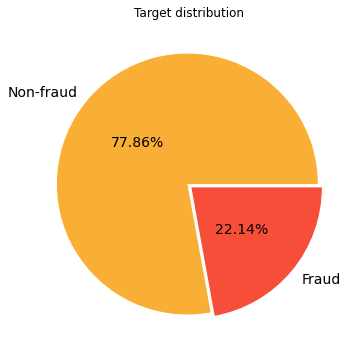

In [15]:
# Inspect target distribution
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[6,6])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

Esto está bueno:

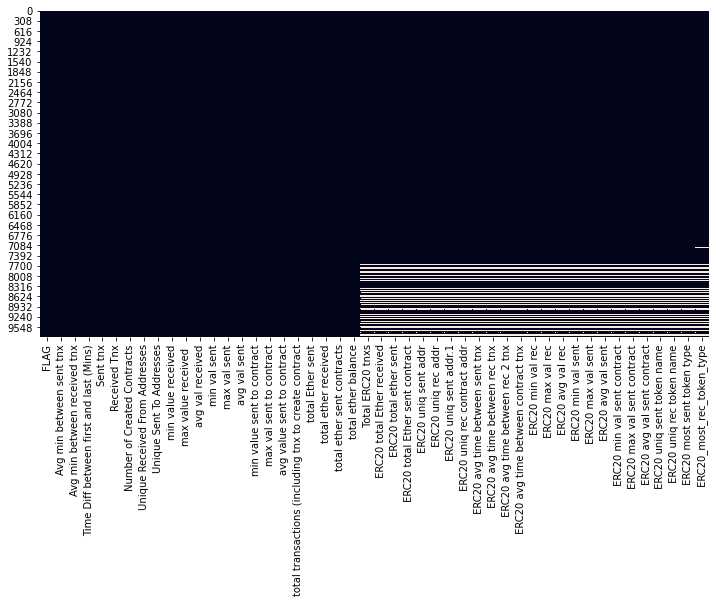

In [16]:
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

Esto por qué?

In [17]:
# Drop the two categorical features
categories = df.select_dtypes('O').columns.astype('category')
df.drop(df[categories], axis=1, inplace=True)

Esto se puede hacer de otras maneras:

In [18]:
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)

Esta no la sabía:

### Ojo:

Variance is range-dependent, therefore we need to do normalization before applying this technique.

In [19]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                    

In [22]:
# Recheck the Correlation matrix
# corr = df.corr()

# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)]=True
# with sns.axes_style('white'):
#     fig, ax = plt.subplots(figsize=(18,10))
#     sns.heatmap(corr,  mask=mask, annot=False, center=0, linewidths=0.1, square=True)

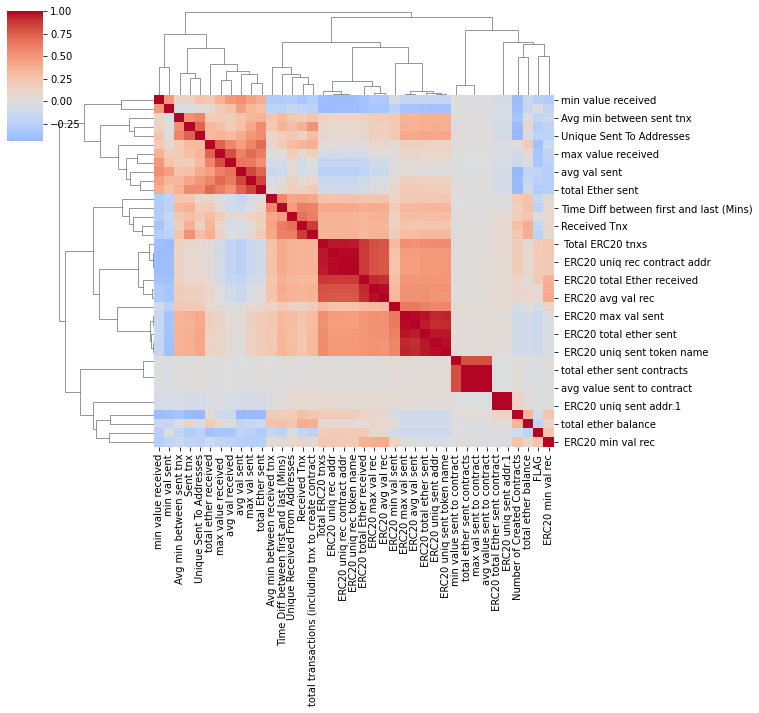

In [23]:
# calculate correlation matrix
## using non-parametric test of correlation (kendall), since some features are binary
corrs = df.select_dtypes(include=np.number).corr(method = 'kendall')

# plot clustered heatmap of correlations
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0);

Esto no sé cómo se justifica:

In [24]:
drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
        ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
        'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)

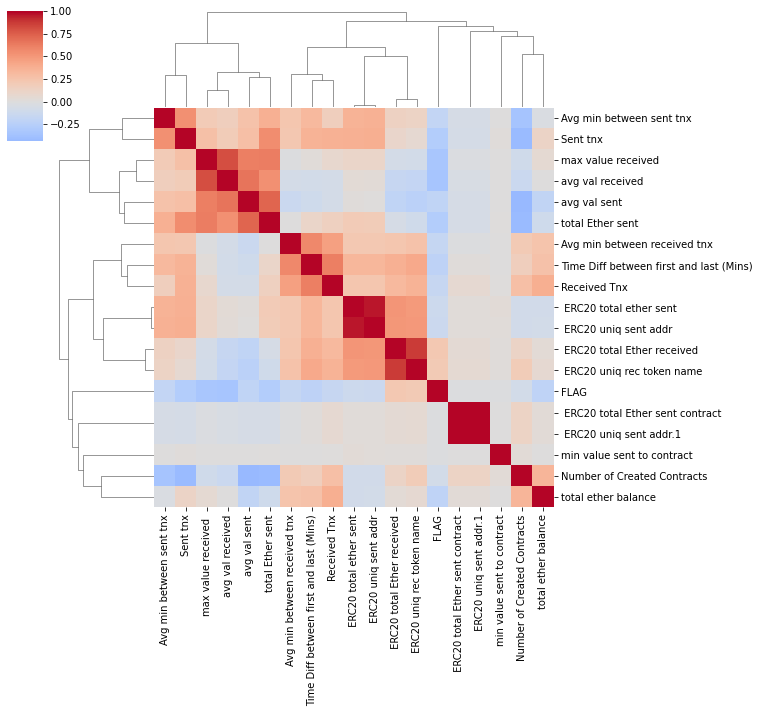

In [25]:
# recheck calculate correlation matrix
## using non-parametric test of correlation (kendall), since some features are binary
corrs = df.select_dtypes(include=np.number).corr(method = 'kendall')

# plot clustered heatmap of correlations
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0);

In [26]:
# Some features present a small distribution
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column min value sent to contract has the following distribution: 
0.00    9839
0.02       1
0.01       1
Name: min value sent to contract, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
0.0    9813
1.0      26
2.0       1
3.0       1
Name:  ERC20 uniq sent addr.1, dtype: int64


It can be observed that the values of these two variables are mosty 0s. Thus, both features will be discarded since they will not be helpful for our model

In [27]:
drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
print(df.shape)
df.head()

(9841, 17)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,45.806785,6.589513,1.200681,865.691093,-279.224419,3.558854e+07,3.560317e+07,0.0,30.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,2.613269,0.385685,0.032844,3.087297,-0.001819,4.034283e+02,2.260809e+00,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,1.165453,0.358906,1.794308,3.588616,0.000441,5.215121e+02,0.000000e+00,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,500.000000,99.488840,70.001834,1750.045862,-854.646303,1.711105e+04,1.141223e+04,0.0,2.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,12.802411,2.671095,0.022688,104.318883,-50.896986,1.628297e+05,1.235399e+05,0.0,4.0,27.0


In [28]:
# separo en X e y:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(9841, 16) (9841,)


In [31]:
# Split into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 16) (7872,)
(1969, 16) (1969,)


Y esto??

In [34]:
# Normalize the training features
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

In [36]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df.head()

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,1.294061,1.151313,1.393751,1.591951,1.017881,-0.401539,1.170696,0.988757,0.651223,1.416308,-0.007274,1.815951,2.508169,-0.038483,2.398649,1.831406
1,-1.096066,-1.184221,-1.638410,-1.391726,-1.785005,-0.401539,-1.407378,-1.283886,-1.138468,-1.252291,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,0.226082
2,-0.006354,0.213137,1.103220,1.970707,1.876994,-0.401539,0.613575,-0.995919,-0.869934,1.171479,-0.006819,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
3,-1.096066,1.220438,0.195684,-1.391726,-0.618856,2.490307,-0.871196,-0.822389,-1.138468,-1.252291,-0.006832,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
4,0.628503,-1.121221,-0.904665,-0.206187,-0.618856,-0.401539,0.889875,1.277099,1.332663,0.787323,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019


Oversampling using SMOTE:

In [39]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((7872, 16), (7872,))
Shape of the training after SMOTE: ((12230, 16), (12230,))


Logistic Regression:

In [42]:
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)

preds = LR.predict(norm_test_f)

              precision    recall  f1-score   support

           0       0.97      0.89      0.92      1547
           1       0.68      0.88      0.77       422

    accuracy                           0.89      1969
   macro avg       0.82      0.89      0.85      1969
weighted avg       0.90      0.89      0.89      1969

[[1372  175]
 [  49  373]]


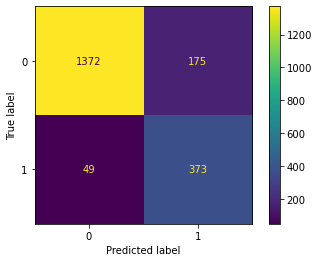

In [55]:
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
_ = plot_confusion_matrix(LR, norm_test_f, y_test)

In [50]:
def draw_cm(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  df_cm = pd.DataFrame(cm_norm)
  plt.figure(figsize = (6,4))
  sns.heatmap(df_cm, annot=True, cmap="Blues")
  plt.xlabel("Predicted class")
  plt.ylabel("True class")
  plt.show()
  print("Accuracy: {0:.3f}".format(accuracy_score(y_test, y_pred)))
  print("Precision: {0:.3f}".format(precision_score(y_test, y_pred)))
  print("Recall: {0:.3f}".format(recall_score(y_test, y_pred)))
  print("F1 Score: {0:.3f}".format(f1_score(y_test, y_pred)))

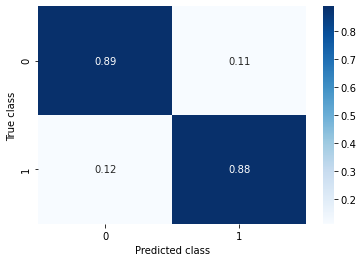

Accuracy: 0.886
Precision: 0.681
Recall: 0.884
F1 Score: 0.769


In [53]:
draw_cm(y_test, preds)